In [ ]:
from google.colab import drive
import zipfile, os, urllib.request, glob, math
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import zipfile, os, urllib.request, glob, math, shutil
from sklearn.model_selection import StratifiedKFold
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
metadata = pd.read_csv('drive/MyDrive/app_metadata.csv')
metadata.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,...,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           2298 non-null   object 
 1   lesion_id            2298 non-null   int64  
 2   smoke                1494 non-null   object 
 3   drink                1494 non-null   object 
 4   background_father    1480 non-null   object 
 5   background_mother    1476 non-null   object 
 6   age                  2298 non-null   int64  
 7   pesticide            1494 non-null   object 
 8   gender               1494 non-null   object 
 9   skin_cancer_history  1494 non-null   object 
 10  cancer_history       1494 non-null   object 
 11  has_piped_water      1494 non-null   object 
 12  has_sewage_system    1494 non-null   object 
 13  fitspatrick          1494 non-null   float64
 14  region               2298 non-null   object 
 15  diameter_1           1494 non-null   f

In [ ]:
metadata.isna().sum()

patient_id               0
lesion_id                0
smoke                  804
drink                  804
background_father      818
background_mother      822
age                      0
pesticide              804
gender                 804
skin_cancer_history    804
cancer_history         804
has_piped_water        804
has_sewage_system      804
fitspatrick            804
region                   0
diameter_1             804
diameter_2             804
diagnostic               0
itch                     0
grew                     0
hurt                     0
changed                  0
bleed                    0
elevation                0
img_id                   0
biopsed                  0
dtype: int64

In [ ]:
metadata.diagnostic.value_counts()

BCC    845
ACK    730
NEV    244
SEK    235
SCC    192
MEL     52
Name: diagnostic, dtype: int64

Διαχωρίζω τα πεδία σε categorical και numerical.

In [ ]:
numerical_vars = ['age', 'diameter_1', 'diameter_2']
categorical_vars = sorted(list(set(metadata.columns.tolist()) - set(numerical_vars) - set(['patient_id', 'lesion_id','img_id', 'biopsed'])))
categorical_vars

['background_father',
 'background_mother',
 'bleed',
 'cancer_history',
 'changed',
 'diagnostic',
 'drink',
 'elevation',
 'fitspatrick',
 'gender',
 'grew',
 'has_piped_water',
 'has_sewage_system',
 'hurt',
 'itch',
 'pesticide',
 'region',
 'skin_cancer_history',
 'smoke']

Ελέγχω τις τιμές που λαμβάνει κάθε κατηγορική μεταβλητή.

In [ ]:
for i in categorical_vars:
  print("All unique vals of column: ", i)
  print(metadata[i].unique())
  print("")

All unique vals of column:  background_father
[nan 'POMERANIA' 'GERMANY' 'BRAZIL' 'NETHERLANDS' 'ITALY' 'POLAND' 'UNK'
 'PORTUGAL' 'BRASIL' 'CZECH' 'AUSTRIA' 'SPAIN' 'ISRAEL']

All unique vals of column:  background_mother
[nan 'POMERANIA' 'ITALY' 'GERMANY' 'BRAZIL' 'UNK' 'POLAND' 'NORWAY'
 'PORTUGAL' 'NETHERLANDS' 'FRANCE' 'SPAIN']

All unique vals of column:  bleed
['False' 'True' 'UNK']

All unique vals of column:  cancer_history
[nan True False]

All unique vals of column:  changed
['False' 'True' 'UNK']

All unique vals of column:  diagnostic
['NEV' 'BCC' 'ACK' 'SEK' 'SCC' 'MEL']

All unique vals of column:  drink
[nan False True]

All unique vals of column:  elevation
['False' 'True' 'UNK']

All unique vals of column:  fitspatrick
[nan  3.  1.  2.  4.  5.  6.]

All unique vals of column:  gender
[nan 'FEMALE' 'MALE']

All unique vals of column:  grew
['False' 'True' 'UNK']

All unique vals of column:  has_piped_water
[nan True False]

All unique vals of column:  has_sewage_system



Αξίζει να σημειωθεί ότι υπάρχει διαφορά μεταξύ nan και UNK τιμών. Η διαφορά είναι ότι nan τιμές σημαίνει ότι για οποιοδήποτε λόγο η πληροφορία λείπει ή χάθηκε, ενώ οι τιμές UNK έχουν αυτή τη τιμή γιατί ο ασθενής απάντησε με αυτό το τρόπο. Δηλαδή ο ασθενής δεν ξέρει την απάντηση στο ερώτημα.

Το γεγονός ότι ο ασθενής δεν γνωρίζει την απάντηση είναι από μόνο του μία πληροφορία. Στη συνέχεια βλέπουμε, για κάθε κατηγορική μεταβλητή πόσες τιμές είναι UNK.


In [ ]:
for i in categorical_vars:
  print("All UNK vals of column: ", i)
  print(len(metadata.loc[metadata[i] == 'UNK']))
  print("")

All UNK vals of column:  background_father
95

All UNK vals of column:  background_mother
84

All UNK vals of column:  bleed
6

All UNK vals of column:  cancer_history
0

All UNK vals of column:  changed
396

All UNK vals of column:  diagnostic
0

All UNK vals of column:  drink
0

All UNK vals of column:  elevation
2

All UNK vals of column:  fitspatrick
0

All UNK vals of column:  gender
0

All UNK vals of column:  grew
402

All UNK vals of column:  has_piped_water
0

All UNK vals of column:  has_sewage_system
0

All UNK vals of column:  hurt
10

All UNK vals of column:  itch
6

All UNK vals of column:  pesticide
0

All UNK vals of column:  region
0

All UNK vals of column:  skin_cancer_history
0

All UNK vals of column:  smoke
0



Οι UNK τιμές θα μπορούσαν να λάβουν μία ξεχωριστή κατηγορία. Αυτό σημαίνει ότι η κατηγορία UNK θα πρέπει να περιέχεται σαν επιλογή και στην εφαρμογή. Ωστόσο, αυτή η τιμή, εκτός του γεγονότος ότι περιλαμβάνεται σε μικρό αριθμό(με εξαίρεση τα πεδία grew, changed), μπορεί να δημιουργήσει σύγχυση στο χρήστη της εφαρμογής (UNK μπορεί να σημαίνει δεν θέλω να απαντήσω, το οποίο είναι λάθος ερμηνεία). Επιπλέον, έχοντας κάνει πειραματισμούς στα πεδία grew,changed για την δημιουργία ή μη ξεχωριστής κατηγορίας UNK, τα αποτελέσματα δεν έδειξαν αξιοσημείωτη διαφορά. Για τους λόγους αυτούς αποφασίστηκε το imputation (ανάθεση τιμών) στις τιμές UNK, σε όλα τα πεδία. Τα πεδία συμπληρώνονται είτε randomly με μία άλλη έγκυρη τιμή του εκάστοτε πεδίου, είτε χρησιμοποιώντας predictive models για την ανάθεση τιμών (βλέπε FeatureSelection).

In [ ]:
print(metadata.loc[metadata['changed'] == 'UNK'].diagnostic.value_counts())
print(metadata.loc[metadata['grew'] == 'UNK'].diagnostic.value_counts())

BCC    266
SCC     75
NEV     36
MEL      9
SEK      8
ACK      2
Name: diagnostic, dtype: int64
BCC    266
SCC     75
NEV     36
MEL     11
SEK      8
ACK      6
Name: diagnostic, dtype: int64


Τα αποτελέσματα από το παραπάνω κελί είναι ενδιαφέροντα. Οι περισσότερες τιμές που είναι UNK στα changed και grew βρίσκονται στα ίδια entries.

In [ ]:
metadata.loc[metadata['changed'] == 'UNK'].head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
11,PAT_967,1827,False,False,POMERANIA,POMERANIA,34,True,FEMALE,True,...,4.0,BCC,True,UNK,False,UNK,True,True,PAT_967_1827_247.png,True
15,PAT_741,1401,True,False,POMERANIA,POMERANIA,77,False,MALE,False,...,13.0,BCC,True,UNK,False,UNK,False,True,PAT_741_1401_619.png,True
19,PAT_821,1547,False,False,POMERANIA,POMERANIA,64,False,FEMALE,True,...,5.0,BCC,True,UNK,False,UNK,False,True,PAT_821_1547_77.png,True
21,PAT_875,1668,False,False,POMERANIA,POMERANIA,61,True,MALE,True,...,10.0,BCC,False,UNK,False,UNK,False,True,PAT_875_1668_588.png,True
24,PAT_106,159,False,False,POMERANIA,POMERANIA,71,False,FEMALE,True,...,3.0,BCC,True,UNK,True,UNK,True,False,PAT_106_159_325.png,True


In [ ]:
temp_changed = metadata.loc[metadata['changed'] == 'UNK']
temp_grew = metadata.loc[metadata['grew'] == 'UNK']

print("Number of UNK in changed feature: ", len(temp_changed))
print("Value counts for grew feature that are included in changed feature:", temp_changed.grew.value_counts())

print("Number of UNK in grew feature:", len(temp_grew))
print("Value counts for changed feature that are included in grew feature:", temp_grew.changed.value_counts())

Number of UNK in changed feature:  396
Value counts for grew feature that are included in changed feature: UNK     394
True      2
Name: grew, dtype: int64
Number of UNK in grew feature: 402
Value counts for changed feature that are included in grew feature: UNK      394
False      5
True       3
Name: changed, dtype: int64


In [ ]:
metadata[categorical_vars] = metadata[categorical_vars].fillna('UNKN')
metadata.isna().sum()

patient_id               0
lesion_id                0
smoke                    0
drink                    0
background_father        0
background_mother        0
age                      0
pesticide                0
gender                   0
skin_cancer_history      0
cancer_history           0
has_piped_water          0
has_sewage_system        0
fitspatrick              0
region                   0
diameter_1             804
diameter_2             804
diagnostic               0
itch                     0
grew                     0
hurt                     0
changed                  0
bleed                    0
elevation                0
img_id                   0
biopsed                  0
dtype: int64

Είναι σημαντικό να αναφερθεί ότι οι nan τιμές δεν πρέπει να λάβουν ξεχωριστή κατηγορία, καθώς αυτό θα οδηγήσει σε παραπλανητικά αποτελέσματα ως προς την επίδοση του μοντέλου.
Ο λόγος που μπορεί να συμβεί αυτό είναι γιατί το μοντέλο θα συσχετίσει τις nan τιμές με κάποια συγκεκριμένη κλάση. Για παράδειγμα αν το μοντέλο λάβει nan τιμή στο πεδίο gender, θα συσχετίσει αυτή τη τιμή με μία από τις τρείς κλάσεις που φαίνονται παρακάτω για το πεδίο gender. Επομένως θα συσχετιστεί το γεγονός ότι λείπει η τιμή, με την κατηγοριοποίηση, κάτι το οποίο είναι λάθος για αυτή τη βάση.Αυτό θα αυξήσει την επίδοση του μοντέλου, ωστόσο είναι λάθος να θεωρήσουμε ότι έχει σχέση με την πραγματικότητα (βλέπε FeatureSelection).

In [ ]:
for i in categorical_vars:
  print(i)
  print(metadata.loc[metadata[i] == 'UNKN'].diagnostic.value_counts())
  print("")

background_father
ACK    452
SEK    195
NEV    171
Name: diagnostic, dtype: int64

background_mother
ACK    455
SEK    195
NEV    172
Name: diagnostic, dtype: int64

bleed
Series([], Name: diagnostic, dtype: int64)

cancer_history
ACK    447
SEK    188
NEV    169
Name: diagnostic, dtype: int64

changed
Series([], Name: diagnostic, dtype: int64)

diagnostic
Series([], Name: diagnostic, dtype: int64)

drink
ACK    447
SEK    188
NEV    169
Name: diagnostic, dtype: int64

elevation
Series([], Name: diagnostic, dtype: int64)

fitspatrick
ACK    447
SEK    188
NEV    169
Name: diagnostic, dtype: int64

gender
ACK    447
SEK    188
NEV    169
Name: diagnostic, dtype: int64

grew
Series([], Name: diagnostic, dtype: int64)

has_piped_water
ACK    447
SEK    188
NEV    169
Name: diagnostic, dtype: int64

has_sewage_system
ACK    447
SEK    188
NEV    169
Name: diagnostic, dtype: int64

hurt
Series([], Name: diagnostic, dtype: int64)

itch
Series([], Name: diagnostic, dtype: int64)

pesticide
AC

In [ ]:
metadata.loc[metadata['gender'] == 'UNKN'].head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,UNKN,UNKN,UNKN,UNKN,8,UNKN,UNKN,UNKN,...,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
2,PAT_1545,1867,UNKN,UNKN,UNKN,UNKN,77,UNKN,UNKN,UNKN,...,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,UNKN,UNKN,UNKN,UNKN,75,UNKN,UNKN,UNKN,...,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
5,PAT_1549,1882,UNKN,UNKN,UNKN,UNKN,53,UNKN,UNKN,UNKN,...,NaN,SEK,True,False,False,False,False,True,PAT_1549_1882_230.png,False
8,PAT_1995,4080,UNKN,UNKN,UNKN,UNKN,68,UNKN,UNKN,UNKN,...,NaN,ACK,True,False,False,True,False,False,PAT_1995_4080_695.png,False


Από τη στιγμή που οι τιμές nan και UNK, θα δεχτούν την ίδια διαχείριση, θα αναθέσουμε την ίδια τιμή και στις δύο.

In [ ]:
metadata.replace('UNKN', 'UNK', inplace = True)
metadata.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,UNK,UNK,UNK,UNK,8,UNK,UNK,UNK,...,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,UNK,UNK,UNK,UNK,77,UNK,UNK,UNK,...,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,UNK,UNK,UNK,UNK,75,UNK,UNK,UNK,...,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True


Ελέγχω τις αριθημτικές μεταβλητές.

In [ ]:
for i in numerical_vars:
  print("Stats for variable:", i)
  print("Number of NaN values: ",metadata[i].isna().sum())
  print("Mean: ", metadata[i].mean())
  print("Std: ", metadata[i].std())
  print("Min: ", metadata[i].min())
  print("Max: ", metadata[i].max())
  print("")

Stats for variable: age
Number of NaN values:  0
Mean:  60.46475195822455
Std:  15.894866347034222
Min:  6
Max:  94

Stats for variable: diameter_1
Number of NaN values:  804
Mean:  11.897054886211514
Std:  8.63449239015042
Min:  0.0
Max:  100.0

Stats for variable: diameter_2
Number of NaN values:  804
Mean:  8.852208835341367
Std:  5.797036434293362
Min:  0.0
Max:  70.0



Μετατροπή NaN αριθμητικών τιμών σε -5.

In [ ]:
metadata[numerical_vars] = metadata[numerical_vars].fillna(-5)
metadata.isna().sum()

patient_id             0
lesion_id              0
smoke                  0
drink                  0
background_father      0
background_mother      0
age                    0
pesticide              0
gender                 0
skin_cancer_history    0
cancer_history         0
has_piped_water        0
has_sewage_system      0
fitspatrick            0
region                 0
diameter_1             0
diameter_2             0
diagnostic             0
itch                   0
grew                   0
hurt                   0
changed                0
bleed                  0
elevation              0
img_id                 0
biopsed                0
dtype: int64

In [ ]:
metadata_wdp = metadata.drop_duplicates(subset = ['lesion_id'])
print('Length of dataset without duplicates is: ', len(metadata_wdp))

Length of dataset without duplicates is:  1641


In [ ]:
metadata_wdp.diagnostic.value_counts()

BCC    574
ACK    550
NEV    182
SEK    169
SCC    136
MEL     30
Name: diagnostic, dtype: int64

Κάνω plot τα distributions του πεδίου diagnostic.

Text(0.5, 1.0, 'Κατανομή των κατηγοριών(diagnostic) χωρίς διπλότυπα')

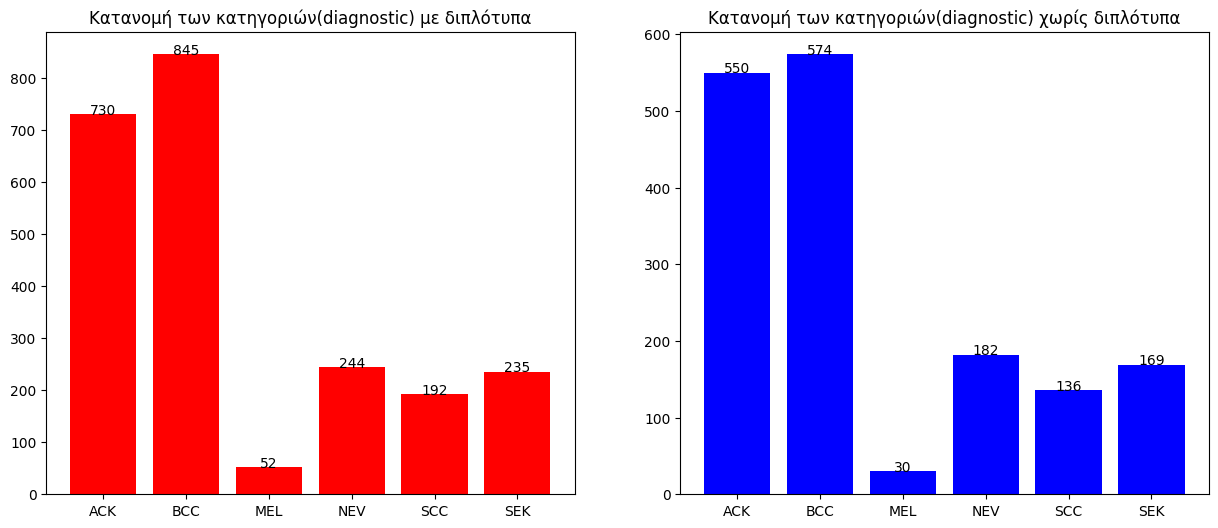

In [ ]:
categories = sorted(metadata.diagnostic.unique().tolist())

categories_values_dup = [0] * 6
for i in metadata.diagnostic.value_counts().to_dict().items():
  categories_values_dup[categories.index(i[0])] = i[1]

categories_values_no_dup = [0] * 6
for i in metadata_wdp.diagnostic.value_counts().to_dict().items():
  categories_values_no_dup[categories.index(i[0])] = i[1]

def addlabels(x,y):
  for i in range(len(x)):
    plt.text(i, y[i], y[i], ha = 'center')

fig = plt.figure(figsize = (15, 6))

plt.subplot(1,2,1)
plt.bar(categories,categories_values_dup,color = 'red')

addlabels(categories,categories_values_dup)
plt.title("Κατανομή των κατηγοριών(diagnostic) με διπλότυπα")

plt.subplot(1,2,2)
plt.bar(categories,categories_values_no_dup,color = 'blue')

addlabels(categories,categories_values_no_dup)
plt.title("Κατανομή των κατηγοριών(diagnostic) χωρίς διπλότυπα")

Ορίζω τους αλγορίθμους cramer's v και anova(για μεταβλητές με κανονική κατανομή).

In [ ]:
import scipy.stats as ss

#categorical - categorical
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


Μετατρέπω το πεδίο diagnostic σε αριθμητικές τιμές.

In [ ]:
diagnostics_list = sorted(list(metadata['diagnostic'].unique()))
column = metadata['diagnostic']
to_append = []

for j in list(column):
  to_append.append(diagnostics_list.index(j))

metadata['diagnostic'] = to_append
metadata.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,UNK,UNK,UNK,UNK,8,UNK,UNK,UNK,...,-5.0,3,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,5.0,1,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,UNK,UNK,UNK,UNK,77,UNK,UNK,UNK,...,-5.0,0,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,UNK,UNK,UNK,UNK,75,UNK,UNK,UNK,...,-5.0,0,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,5.0,1,True,True,False,False,True,True,PAT_684_1302_588.png,True


Υπολογίζω συσχέτιση των αριθμητικών τιμών με το πεδίο diagnostic.

In [ ]:
import scipy.stats as ss

dataset = metadata
#dataset = metadata_wdp

def calculate_eta_squared(kruskal_statistic, num_groups, total_observations):
    eta_squared = (kruskal_statistic - num_groups + 1) / (total_observations - num_groups)
    return eta_squared

vars_to_check = ['age', 'diameter_1', 'diameter_2']

for i in vars_to_check:

  temp_dataset = dataset.loc[dataset[i] != -5]

  print("Print stats for variable", i)
  #shapiro-wilk test for normality
  print(ss.shapiro(np.array(temp_dataset[i].tolist())))

  listes = []
  total_observations = 0
  for group in temp_dataset.groupby('diagnostic'):

    total_observations += len(group[1][i].tolist())
    listes.append(group[1][i].tolist())

  #kruskal-wallis test of association
  statistic, _ = ss.kruskal(*listes)
  eta_k = calculate_eta_squared(statistic,6,total_observations)
  print(eta_k)

Print stats for variable age
ShapiroResult(statistic=0.9751001000404358, pvalue=1.38035493301148e-19)
0.20757960771113176
Print stats for variable diameter_1
ShapiroResult(statistic=0.6987259984016418, pvalue=1.401298464324817e-45)
0.027957477991081628
Print stats for variable diameter_2
ShapiroResult(statistic=0.7720015645027161, pvalue=2.2587529946451726e-41)
0.030486591294661757


Υπολογίζω συσχέτιση μεταξύ κατηγορικών μεταβλητών.

Associations with diagnostic:  [0.07305344 0.04090845 0.49905089 0.         0.38567926 1.
 0.         0.52031191 0.12039691 0.06950524 0.50072411 0.07084567
 0.07533261 0.3923203  0.52620022 0.13307108 0.28370607 0.05969784
 0.12790594]


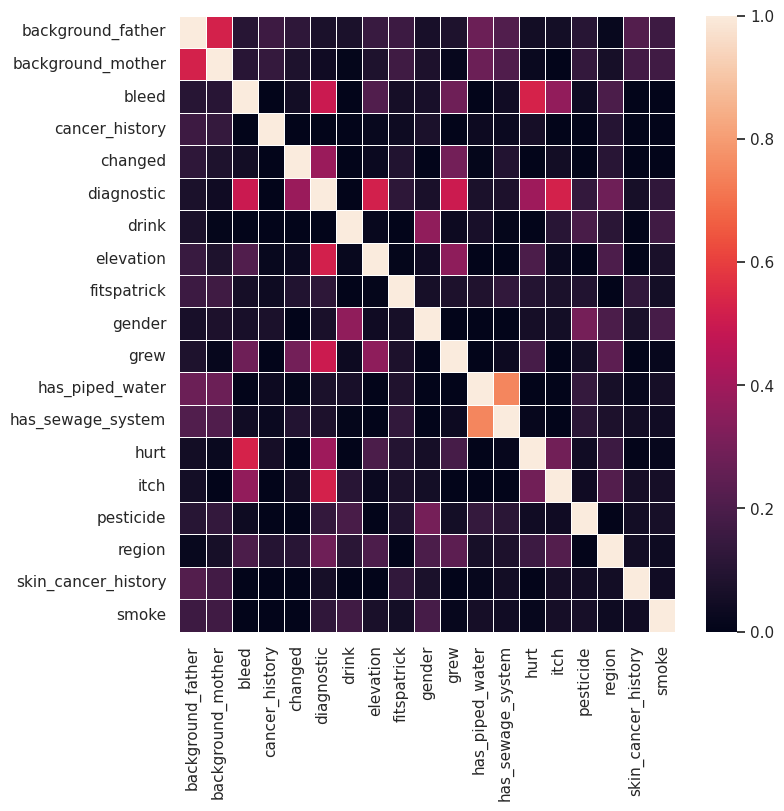

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt

total_features = len(categorical_vars)
correlations_array = np.empty((total_features,total_features))
#metadata = metadata_wdp
for counter_i,i in enumerate(categorical_vars):

  for counter_k,k in enumerate(categorical_vars):

    if i == k:
      correlations_array[counter_i][counter_k] = 1
      continue

    temp_df = metadata.loc[(metadata[i] != 'UNK') & (metadata[k] != 'UNK')].copy(deep = True)# η ανάλυση γίνεται χωρίς τις UNK - nan τιμές.

    correlations_array[counter_i][counter_k] = cramers_v(temp_df[i], temp_df[k])

print("Associations with diagnostic: ", correlations_array[5])
sns.set(rc={'figure.figsize':(8,8)})
ax = sns.heatmap(correlations_array, linewidth=0.5)
ax.set_xticklabels(categorical_vars)
ax.set_yticklabels(categorical_vars)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [ ]:
metadata.to_csv('drive/MyDrive/metadata_processed.csv', index = False)